# Coulomb Matrices
In this notebook, we explore Coulomb matrices as molecular representations.

We will use the same kernel as in the [Fingerprints and SMILES](./1-Fingerprints-and-SMILES.ipynb) notebook, but the QM7 dataset.

The QM7 dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules. It contains the Coulomb matrix representation of these molecules and their atomization energies computed similarly to the FHI-AIMS implementation of the Perdew-Burke-Ernzerhof hybrid functional (PBE0). This dataset features a large variety of molecular structures such as double and triple bonds, cycles, carboxy, cyanide, amide, alcohol and epoxy.

## Downloading the dataset
It is not necessary for you to download the dataset, as it is already included in [../data/qm7.mat](../data/qm7.mat). This was obtained via the following terminal command:
```
wget http://quantum-machine.org/data/qm7.mat
```

## Loading the data

In [2]:
import scipy

# Load the QM7 dataset as a Python dictionary
raw_qm7 = scipy.io.loadmat("../data/qm7.mat")

The dataset is composed of five multi-dimensional arrays:
- X (7165 x 23 x 23) - Coulomb matrices
- T (7165) - atomization energies (the labels)
- P (5 x 1433) - cross-validation splits
- Z (7165) - atomic charge of each atom in the molecules
- R (7165 x 3) - Cartesian coordinates of each atom in the molecules

In [3]:
X = raw_qm7["X"] # Coulomb matrices
T = raw_qm7["T"] # atomization energies
P = raw_qm7["P"] # cross-validation splits
Z = raw_qm7["Z"] # atomic numbers
R = raw_qm7["R"] # coordinates

To make it a bit easier to "see" the molecules, let's convert a few of them into RDKit molecule objects and draw them. This is non-trivial, as we have to use the coordinates and atomic numbers to create an initial conformer object, and then infer bonds based on the inter-atomic distances.

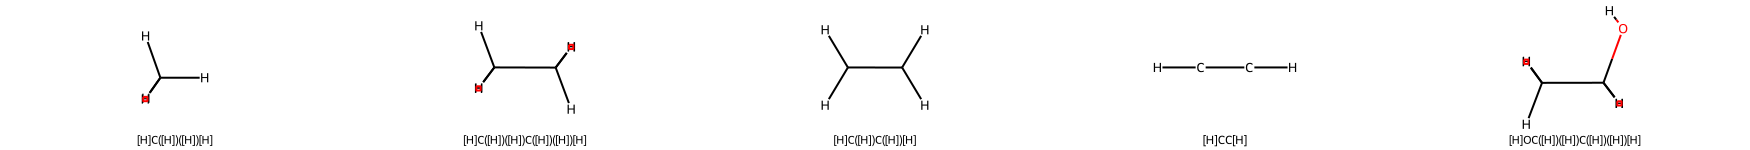

In [113]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

# Covalent radii in angstroms (simplified, only a few elements included)
covalent_radii = {
    1: 0.31,  # Hydrogen
    6: 0.76,  # Carbon
    7: 0.71,  # Nitrogen
    8: 0.66,  # Oxygen
}

def add_bonds_based_on_distances(mol, R, Z, threshold=1.35):
    nonzero_idc = np.nonzero(Z)  # Idenfity zero values (padding) to remove them below
    num_atoms = len(Z[nonzero_idc])
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            distance = np.linalg.norm(R[i] - R[j])
            max_bond_length = covalent_radii[int(Z[i])] + covalent_radii[int(Z[j])] + threshold
            if distance < max_bond_length:
                mol.AddBond(i, j, Chem.BondType.SINGLE)

def coordinates_to_mol(R, Z):
    mol = Chem.RWMol()  # Create a new molecule
    nonzero_idc = np.nonzero(Z)
    num_atoms = len(Z[nonzero_idc])
    conf = Chem.Conformer(num_atoms)

    # Add atoms to the molecule and set coordinates
    for i, (atomic_num, coord) in enumerate(zip(Z, R)):
        if atomic_num > 0:
            atom = Chem.Atom(int(atomic_num))
            idx = mol.AddAtom(atom)
            conf.SetAtomPosition(idx, Chem.rdGeometry.Point3D(float(coord[0]), float(coord[1]), float(coord[2])))

    mol.AddConformer(conf)

    # Add bonds based on distances
    add_bonds_based_on_distances(mol, R, Z)

    # Calculate implicit valence
    for atom in mol.GetAtoms():
        atom.UpdatePropertyCache(strict=False)

    return mol

# Visualize the first five molecules in QM7, with SMILES as labels
molecules = []
smiles = []
for i in range(5):
    molecules.append(coordinates_to_mol(R[i], Z[i]))
    smiles.append(Chem.MolToSmiles(molecules[-1]))

Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(350, 150), legends=smiles)

## Coulomb Matrices
In a Coulomb matrix (CMs), where each element of the matrix captures the Coulombic interaction between pairs of atoms in a conformer, combining nuclear charge and interatomic distances. Below we compute the Coulomb matrix for the first molecule above (methane), using the provided coordinates:

In [115]:
# Define a function for generating the Coulomb matrix given a set of coordinates and atomic numbers
def get_coulomb_matrix(R, Z):
    nonzero_idc = np.nonzero(Z)
    num_atoms = len(Z[nonzero_idc])
    coulomb_matrix = np.zeros((num_atoms, num_atoms))

    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * Z[i]**2.4
            else:
                distance = np.linalg.norm(R[i] - R[j])
                coulomb_matrix[i, j] = Z[i] * Z[j] / distance

    return coulomb_matrix

# Compute the Coulomb matrix for methane (the first molecule in R and Z)
coulomb_matrix_methane = get_coulomb_matrix(R[0], Z[0])

print("Coulomb matrix for methane:")
print(coulomb_matrix_methane)

Coulomb matrix for methane:
[[36.85811234  2.90761209  2.90763259  2.90756464  2.90534854]
 [ 2.90761209  0.5         0.29671997  0.29671845  0.29667813]
 [ 2.90763259  0.29671997  0.5         0.29671896  0.29667839]
 [ 2.90756464  0.29671845  0.29671896  0.5         0.29667675]
 [ 2.90534854  0.29667813  0.29667839  0.29667675  0.5       ]]


Notice that the Coulomb matrix is symmetric.

To compare, we can compute the Coulomb matrices for the second and third molecules above (ethane and ethene, respectively):

In [116]:
# Compute the Coulomb matrices for ethane and ethene
coulomb_matrix_ethane = get_coulomb_matrix(R[1], Z[1])
coulomb_matrix_ethene = get_coulomb_matrix(R[2], Z[2])

print("Coulomb matrix for ethane:")
print(coulomb_matrix_ethane)

print("Coulomb matrix for ethene:")
print(coulomb_matrix_ethene)

Coulomb matrix for ethane:
[[36.85811234 12.59994316  2.90198922  2.90198159  2.90188408  1.47311664
   1.4731003   1.47310483]
 [12.59994316 36.85811234  1.47311807  1.47310114  1.4731015   2.90199995
   2.90197253  2.90188575]
 [ 2.90198922  1.47311807  0.5         0.29826027  0.29825735  0.21177544
   0.21151981  0.17260566]
 [ 2.90198159  1.47310114  0.29826027  0.5         0.29825652  0.21151972
   0.17260502  0.2117742 ]
 [ 2.90188408  1.4731015   0.29825735  0.29825652  0.5         0.17260545
   0.21177392  0.21151982]
 [ 1.47311664  2.90199995  0.21177544  0.21151972  0.17260545  0.5
   0.29826012  0.29825798]
 [ 1.4731003   2.90197253  0.21151981  0.17260502  0.21177392  0.29826012
   0.5         0.29825634]
 [ 1.47310483  2.90188575  0.17260566  0.2117742   0.21151982  0.29825798
   0.29825634  0.5       ]]
Coulomb matrix for ethene:
[[36.85811234 14.26182747  2.92499709  2.92473269  1.50368023  1.503703  ]
 [14.26182747 36.85811234  1.50369978  1.50368011  2.92470026  2.9250

These matrices do not print very well within a Python notebook for large molecules. We can better visualize them using a heatmap:

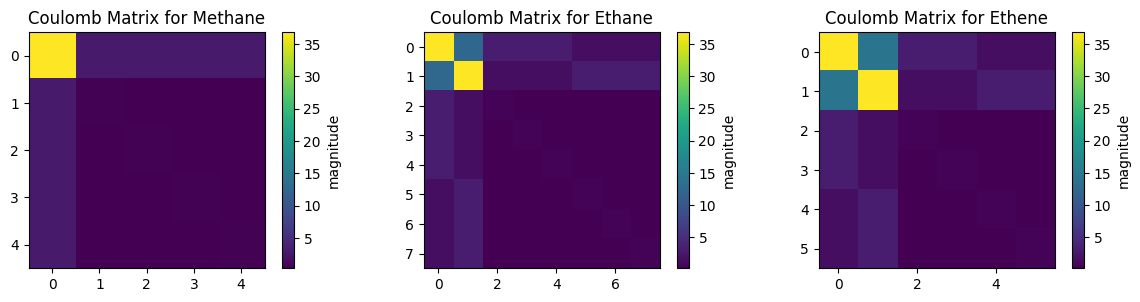

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(coulomb_matrix_methane, cmap='viridis')
plt.colorbar(label='magnitude')
plt.title('Coulomb Matrix for Methane')

plt.subplot(1, 3, 2)
plt.imshow(coulomb_matrix_ethane, cmap='viridis')
plt.colorbar(label='magnitude')
plt.title('Coulomb Matrix for Ethane')

plt.subplot(1, 3, 3)
plt.imshow(coulomb_matrix_ethene, cmap='viridis')
plt.colorbar(label='magnitude')
plt.title('Coulomb Matrix for Ethene')

plt.tight_layout()
plt.show()


Let's look at a more complex molecule, such as caffeine.

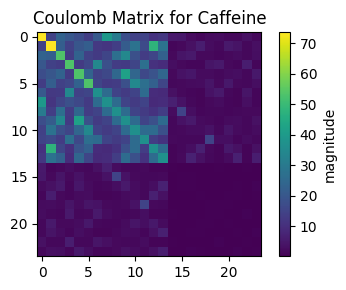

In [130]:
# Atomic numbers for caffeine
Z_caffeine = np.array([8, 8,  # Oxygens
                    7, 7, 7, 7,  # Nitrogens
	                6, 6, 6, 6, 6, 6, 6, 6,  # Carbons
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # Hydrogens

# Approximate positions in angstroms
R_caffeine = np.array([
	[2.1, 0.0, 1.0],     # O1
    [0.0, 3.8, 1.0],     # O2
	[2.1, 2.4, 1.0],     # N1
    [-0.7, 0.0, 1.0],    # N2
    [1.4, 2.4, -1.0],    # N3
    [-0.7, 2.4, -1.0],   # N4
    [0.0, 0.0, 0.0],     # C1
    [1.4, 0.0, 0.0],     # C2
    [2.1, 1.2, 0.0],     # C3
    [1.4, 2.4, 0.0],     # C4
    [0.0, 2.4, 0.0],     # C5
    [-0.7, 1.2, 0.0],    # C6
    [0.0, 3.8, 0.0],     # C7
    [1.4, 3.8, 0.0],     # C8
    [1.4, -0.9, 0.0],    # H1
    [2.5, 1.2, 0.0],     # H2
    [2.1, 3.3, 0.0],     # H3
    [0.0, 4.7, 0.0],     # H4
    [-1.1, 1.2, 0.0],    # H5
    [-0.7, -0.9, 0.0],   # H6
    [-1.1, 3.3, 0.0],    # H7
    [1.4, 4.7, 0.0],     # H8
    [0.0, -0.9, 1.0],    # H9
    [1.4, 3.8, -1.0]     # H10
])

# Compute the Coulomb matrix for caffeine
coulomb_matrix_caffeine = get_coulomb_matrix(R_caffeine, Z_caffeine)

plt.figure(figsize=(4, 3))

plt.imshow(coulomb_matrix_caffeine, cmap='viridis')
plt.colorbar(label='magnitude')
plt.title('Coulomb Matrix for Caffeine')

plt.tight_layout()
plt.show()


## Tips💡

### Use consistent ordering
Note that the resulting Coulomb matrix will be dependent on the order in which it sees the atoms. To avoid issues down the line, it is recommended that you generate these with a consistent node ordering (for instance, highest atomic number first, as we did for caffeine above, or as is done in QM7 by default). This is because most machine learning methods are not permutation invariant, and the order in which you present the rows and columns of your matrix will influence the output.

### Ensure you have good structures
Coulomb matrices are sensitive to interatomic distances. If you have different conformers for a molecule, they will result in different Coulomb matrices.

### Condensing the representation further
Using the eigenvalues of the Coulomb matrix is a viable alternative to using the Coulomb matrix to represent a specific conformer, especially in the context of machine learning and dimensionality reduction. The full Coulomb matrix does not scale well for larger and larger molecules, which can make it cumbersome to work with. In addition to reducing the size of the representation, the eigenvalues of the Coulomb matrix are invariant to node ordering. As such, the eigenvalues of the Coulomb matrix can provide a condensed representation of molecular structure, capturing essential information about the interactions and relative positions of the atoms.